<div style="text-align: center;">
    <h1>Fama-French Factor Mode For Stock Returns</h1>
    </div>
</div>

## 1. Introduction

The Fama-French Five-factor Model, introduced by Eugene Fama and Kenneth French, extends their Three-factor Model to better explain stock returns. It incorporates five factors: Market Risk, Size, Value, Profitability, and Investment. These factors collectively provide a more comprehensive view of the drivers influencing stock performance.

In this assignment, we aim to train the Fama-French Five-factor Model on 20 years of daily data (i.e., 2004-2024) and apply it to predict Apple’s monthly returns.

## 2. Fama-French Factor Model Regression

The five-factor Fama-French model can be illustrated as below,

$$
R_i-R_f = \alpha + \beta_M(R_m-R_f)+ \beta_{SMB}\cdot SMB + \beta_{HML}\cdot HML + \beta_{RMW}\cdot RMW + \beta_{CMA}\cdot CMA + \epsilon 
$$

- $\beta$: factor exposure, sensitivity of single stock to the five factors
- $\alpha$: idiosyncratic return, return that cannot be explained by systematic exposure
- $R_i$: return on stock i
- $R_f$: risk-free rate (assume as zero in the following example)
- $R_M$: return on the market portfolio, can be estimated using index returns, e.g. SPY500
- $R_M - R_f(MKT: Market\ Risk)$: the excess return of the market over the risk-free rate
- $Size\ (SMB: Small\ Minus\ Big)$: the return spread between small-cap and large-cap stocks
- $Value\ (HML: High\ Minus\ Low)$: the return spread between high book-to-market and low book-to-market stocks
- $Profitability\ (RMW: Robust\ Minus\ Weak)$: the return spread between firms with high and low operating profitability
- $Investment\ (CMA: Conservative\ Minus\ Aggressive)$: the return spread between firms that invest conservatively and those that invest aggressively
- $\epsilon$: error term

In [5]:
!pip install -U yfinance
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

## 3. Data

### 3.1 Data Source
- **Factor Data**:
  - Source: Kenneth French's data library ([Link](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html))
  - Dataset: "Fama/French 5 Factors (2x3) [Daily]" CSV
- **Stock Data**:
  - Source: yfinance library
  - Stock: Apple Inc. (AAPL)

### 3.2 Data Overview

- **Factor Data**:
  - The Fama-French 5-Factor (2x3) data categorizes stocks from NYSE, AMEX, and NASDAQ into groups based on size and three characteristics: Value, Profitability, and Investment. This structure forms six value-weight portfolios for each characteristic, with factors such as SMB, HML, RMW, CMA, and <span style="font-style: italic;">R<sub>m</sub> - R<sub>f</sub></span> calculated to capture the returns of small versus big stocks, value versus growth stocks, robust versus weak profitability stocks, conservative versus aggressive investment stocks, and the excess return of the market over the risk-free rate. 
  - The dataset spans daily from July 1963 to December 2024. We subset it to the 20-year period from January 2004 to December 2024.
  
- **Stock Data**:
  - The historical stock price data for Apple (AAPL), retrieved via yfinance, includes fields such as Date, Open, High, Low, Close, Adjusted Close (accounting for stock splits and other adjustments), Volume, Dividends, and Stock Splits. 
  - The dataset spans daily from December 1980 to March 2025. We subset it to the 20-year period from January 2004 to December 2024.

Upon reviewing the datasets, we determined that the data quality is sufficient for our analysis, with no significant issues identified that would necessitate removal.

### 3.3 Factor Data
Below is an snapshot of the Fama-French dataset.

In [2]:
# Load the Fama-French five-factor data
try:
    ff_data_path = 'F-F_Research_Data_5_Factors_2x3_daily.CSV'
    ff_data = pd.read_csv(ff_data_path,
                          delim_whitespace=False,  # Disable whitespace delimiter
                          sep=',',                # Use comma as delimiter
                          skiprows=2,             # Skip the first 2 rows (metadata and blank line)
                          header=1)               # Use the next row (row 2) as the header
    print("Fama-French data loaded successfully.")
except FileNotFoundError:
    print("Error: Fama-French data file not found.")
except pd.errors.EmptyDataError:
    print("Error: Fama-French data file is empty.")
except pd.errors.ParserError:
    print("Error: Fama-French data file format is incorrect.")

# Snapshot of the Fama-French data
print("\nOverview of the Factor Data:")
print(ff_data.head(10))

Fama-French data loaded successfully.

Overview of the Factor Data:
   Unnamed: 0  Mkt-RF   SMB   HML   RMW   CMA     RF
0    19630701   -0.67  0.02 -0.35  0.03  0.13  0.012
1    19630702    0.79 -0.28  0.28 -0.08 -0.21  0.012
2    19630703    0.63 -0.18 -0.10  0.13 -0.25  0.012
3    19630705    0.40  0.09 -0.28  0.07 -0.30  0.012
4    19630708   -0.63  0.07 -0.20 -0.27  0.06  0.012
5    19630709    0.45  0.00  0.09  0.15 -0.01  0.012
6    19630710   -0.18  0.20  0.00  0.05 -0.09  0.012
7    19630711   -0.16  0.12 -0.29 -0.03  0.07  0.012
8    19630712   -0.12  0.01 -0.09  0.09  0.08  0.012
9    19630715   -0.62  0.07 -0.03  0.15 -0.10  0.012


### 3.4 Stock Data
Below is a snapshot of the Apple stock price dataset.

In [3]:
# Retrieve all available stock price data for Apple from yfinance
try:
    stock = yf.Ticker("AAPL")
    AAPL_all_data = stock.history(period="max", auto_adjust=False)
    print("Apple stock data retrieved successfully.")
except Exception as e:
    print(f"Error retrieving Apple stock data: {e}")

# Save the dataset in the same directory as Fama-French five-factor data
AAPL_all_data.to_csv("AAPL_all_data.csv")

# Snapshot of the Apple stock price data
print("\nOverview of the Stock Data:")
print(AAPL_all_data.head(10))

Apple stock data retrieved successfully.

Overview of the Stock Data:
                               Open      High       Low     Close  Adj Close  \
Date                                                                           
1980-12-12 00:00:00-05:00  0.128348  0.128906  0.128348  0.128348   0.098726   
1980-12-15 00:00:00-05:00  0.122210  0.122210  0.121652  0.121652   0.093575   
1980-12-16 00:00:00-05:00  0.113281  0.113281  0.112723  0.112723   0.086707   
1980-12-17 00:00:00-05:00  0.115513  0.116071  0.115513  0.115513   0.088853   
1980-12-18 00:00:00-05:00  0.118862  0.119420  0.118862  0.118862   0.091429   
1980-12-19 00:00:00-05:00  0.126116  0.126674  0.126116  0.126116   0.097009   
1980-12-22 00:00:00-05:00  0.132254  0.132813  0.132254  0.132254   0.101730   
1980-12-23 00:00:00-05:00  0.137835  0.138393  0.137835  0.137835   0.106023   
1980-12-24 00:00:00-05:00  0.145089  0.145647  0.145089  0.145089   0.111603   
1980-12-26 00:00:00-05:00  0.158482  0.159040  0.1

### 3.5 Merge Factor Data and Stock Data
Transform both Fame-French dataset and Apple stock price dataset to be ready for modeling.

In [4]:
# Transform Apple stock price dataset
try:
    AAPL_all_data_adjusted = AAPL_all_data.copy()

    # Filter the data from 2003-12-31 to 2024-12-31
    AAPL_all_data_adjusted = AAPL_all_data_adjusted.loc['2003-12-31':'2024-12-31']

    # Format the Date column
    AAPL_all_data_adjusted.reset_index(inplace=True)
    AAPL_all_data_adjusted['Date'] = AAPL_all_data_adjusted['Date'].dt.strftime('%Y%m%d')

    # Calculate the daily return using the "Adj Close" price
    AAPL_all_data_adjusted['Apple Daily Return'] = AAPL_all_data_adjusted['Adj Close'].pct_change()

    print("Apple stock data transformed successfully.")
except KeyError as e:
    print(f"Error: Missing expected column in Apple stock data - {e}")
except Exception as e:
    print(f"Error transforming Apple stock data: {e}")

Apple stock data transformed successfully.


In [9]:
# Transform Fama-French dataset
try:
    ff_data_adjusted = ff_data.copy()

    # Rename the 'Unnamed: 0' column to 'Date'
    ff_data_adjusted.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

    # Set 'Date' as the index
    ff_data_adjusted.set_index('Date', inplace=True)

    # Filter the data from 2004-01-01 to 2024-12-31
    ff_data_adjusted = ff_data_adjusted.loc['20040102':'20241231']

    # Reset the index if you need 'Date' as a column again
    ff_data_adjusted.reset_index(inplace=True)

    print("Fama-French data transformed successfully.")
except KeyError as e:
    print(f"Error: Missing expected column in Fama-French data - {e}")
except Exception as e:
    print(f"Error transforming Fama-French data: {e}")

Fama-French data transformed successfully.


Now, merge both datasets into one dataset.

In [10]:
# Ensure both datasets have the 'Date' column in the same format (string)
ff_data_adjusted['Date'] = ff_data_adjusted['Date'].astype(str)
AAPL_all_data_adjusted['Date'] = AAPL_all_data_adjusted['Date'].astype(str)

# Perform the inner join on the 'Date' column
merged_data = pd.merge(ff_data_adjusted, AAPL_all_data_adjusted[['Date', 'Apple Daily Return']], on='Date', how='inner')

# Filter the merged data for the specified timeframe
merged_data = merged_data[(merged_data['Date'] >= '20040102') & (merged_data['Date'] <= '20241231')]

# Check for null values
null_values = merged_data.isnull().sum()
print("Null values in each column:\n", null_values)

print(merged_data)

# Validate the merged dataset
if merged_data.empty:
    print("Error: Merged dataset is empty. Please check the data and try again.")
else:
    print("Merged dataset is complete and ready for modeling.")

print("\nOverview of the Merged Data:")
print(merged_data.head(10))

Null values in each column:
 Date                  0
Mkt-RF                0
SMB                   0
HML                   0
RMW                   0
CMA                   0
RF                    0
Apple Daily Return    0
dtype: int64
          Date  Mkt-RF   SMB   HML   RMW   CMA     RF  Apple Daily Return
0     20040102   -0.17  0.79  0.43 -0.58  0.63  0.003           -0.004211
1     20040105    1.20  0.28  0.01 -0.77  0.82  0.003            0.041824
2     20040106    0.20  0.05  0.26 -0.48  0.56  0.003           -0.003610
3     20040107    0.34  0.51 -0.08 -0.52  0.20  0.003            0.022636
4     20040108    0.45  0.30  0.70 -0.89  1.00  0.003            0.034086
...        ...     ...   ...   ...   ...   ...    ...                 ...
5280  20241224    1.11 -0.12 -0.05 -0.13 -0.37  0.017            0.011478
5281  20241226    0.02  1.09 -0.19 -0.44  0.35  0.017            0.003176
5282  20241227   -1.17 -0.44  0.56  0.41  0.03  0.017           -0.013242
5283  20241230   -1.09  0.

## 4. Modeling

### 4.1 Train the Linear Regression Model

In [11]:
# Use sklearn to perform linear regression modeling
# Define the features and target variable
X = merged_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
y = merged_data['Apple Daily Return'] - merged_data['RF']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Get predictions on the test set
y_pred = model.predict(X_test)

# Residuals
residuals = y_test - y_pred

# Degrees of freedom
n = X_train.shape[0]  # Number of observations in the training set
p = X_train.shape[1]  # Number of predictors
df = n - p - 1  # Degrees of freedom

# Standard error of the estimate
sse = np.sum(residuals ** 2)  # Sum of squared errors
mse = sse / df  # Mean squared error
se = np.sqrt(mse)  # Standard error

# Standard errors of coefficients
X_with_intercept = np.column_stack((np.ones(X_train.shape[0]), X_train))
beta = np.append(model.intercept_, model.coef_)  # Include intercept
cov_matrix = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * mse
se_coefficients = np.sqrt(np.diag(cov_matrix))

# t-statistics and p-values
t_stats = beta / se_coefficients
p_values = [2 * (1 - stats.t.cdf(np.abs(t), df)) for t in t_stats]

# Create a summary DataFrame
summary = pd.DataFrame({
    'Coefficient': beta,
    'Std. Error': se_coefficients,
    't-statistic': t_stats,
    'p-value': p_values
}, index=['Intercept'] + X.columns.tolist())

# R-squared and adjusted R-squared
r_squared = model.score(X_test, y_test)
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / df

# Print enhanced summary
print("\nRegression Summary:")
print(summary)
print(f"R-squared: {r_squared:.4f}")
print(f"Adjusted R-squared: {adjusted_r_squared:.4f}")
print(f"Standard Error of the Estimate: {se:.4f}")


Regression Summary:
           Coefficient  Std. Error  t-statistic   p-value
Intercept    -0.004922    0.000140   -35.247394  0.000000
Mkt-RF        0.011394    0.000127    89.784030  0.000000
SMB          -0.001070    0.000238    -4.490428  0.000007
HML          -0.003478    0.000205   -16.949326  0.000000
RMW           0.002983    0.000328     9.080992  0.000000
CMA          -0.001748    0.000425    -4.109663  0.000040
R-squared: 0.3220
Adjusted R-squared: 0.3212
Standard Error of the Estimate: 0.0091


**Observations from the linear regression model include:**
- The t-statistics for Market Risk, Size, Value, Profitability, Investment are approximately 89.8, -4.5, -16.9, 9.1 and -4.1, respectively, with their corresponding p-values all smaller than 0.05. This indicates that these factors are statistically significant.
- The coefficients' signs and magnitudes generally align with Apple's profile as a large-cap, growth-oriented and profitability tech company.
- The R-sqaured of 0.3220 suggests that over 67% of the variance remains unexplained, possibly due to industry-specific factors or idiosyncratic risk not captured by the five-factor model.

### 4.2 Predict Daily Returns

In [12]:
# Predict daily returns using the trained model
merged_data['Apple Predicted Daily Return'] = model.predict(X)

### 4.3 Calculate Monthly Returns

In [13]:
# Convert 'Date' to datetime format for resampling
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Resample to calculate monthly returns
predicted_monthly_returns = merged_data.resample('M', on='Date')['Apple Predicted Daily Return'].sum()
actual_monthly_returns = merged_data.resample('M', on='Date')['Apple Daily Return'].sum()

### 4.4 Compare Predicted with Actual Monthly Returns

In [14]:
# Create a DataFrame to compare predicted and actual monthly returns
comparison_df = pd.DataFrame({
    'Actual Monthly Return': actual_monthly_returns,
    'Predicted Monthly Return': predicted_monthly_returns
})

# Calculate the absolute difference
comparison_df['Absolute Difference between Actual and Predicted'] = (comparison_df['Actual Monthly Return'] - comparison_df['Predicted Monthly Return']).abs()

# Calculate the relative difference (percentage difference)
comparison_df['Relative Difference between Actual and Predicted'] = (comparison_df['Absolute Difference between Actual and Predicted'] / comparison_df['Actual Monthly Return']) * 100

# Format the actual and predicted monthly returns to include the '%' sign
comparison_df['Actual Monthly Return'] = comparison_df['Actual Monthly Return'].map(lambda x: f"{x:.2f}%")
comparison_df['Predicted Monthly Return'] = comparison_df['Predicted Monthly Return'].map(lambda x: f"{x:.2f}%")

# Format the absolute difference and relative difference to include the '%' sign
comparison_df['Absolute Difference between Actual and Predicted'] = comparison_df['Absolute Difference between Actual and Predicted'].map(lambda x: f"{x:.2f}%")
comparison_df['Relative Difference between Actual and Predicted'] = comparison_df['Relative Difference between Actual and Predicted'].map(lambda x: f"{x:.2f}%")

# Print the final comparison DataFrame
print(comparison_df)

           Actual Monthly Return Predicted Monthly Return  \
Date                                                        
2004-01-31                 0.06%                   -0.10%   
2004-02-29                 0.06%                   -0.07%   
2004-03-31                 0.13%                   -0.12%   
2004-04-30                -0.04%                   -0.10%   
2004-05-31                 0.09%                   -0.09%   
...                          ...                      ...   
2024-08-31                 0.03%                   -0.08%   
2024-09-30                 0.02%                   -0.07%   
2024-10-31                -0.03%                   -0.13%   
2024-11-30                 0.05%                   -0.04%   
2024-12-31                 0.05%                   -0.12%   

           Absolute Difference between Actual and Predicted  \
Date                                                          
2004-01-31                                            0.16%   
2004-02-29       

## 5. Analysis

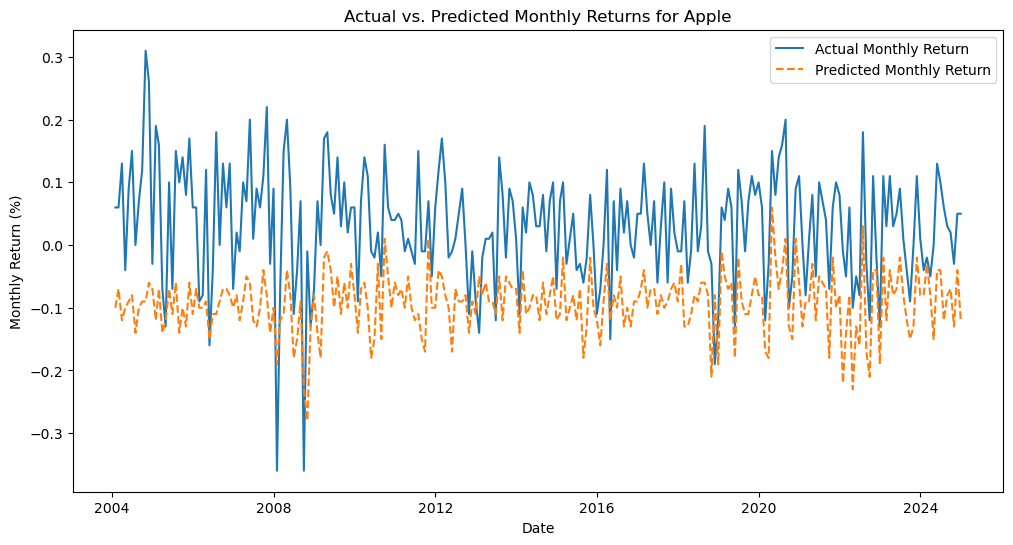

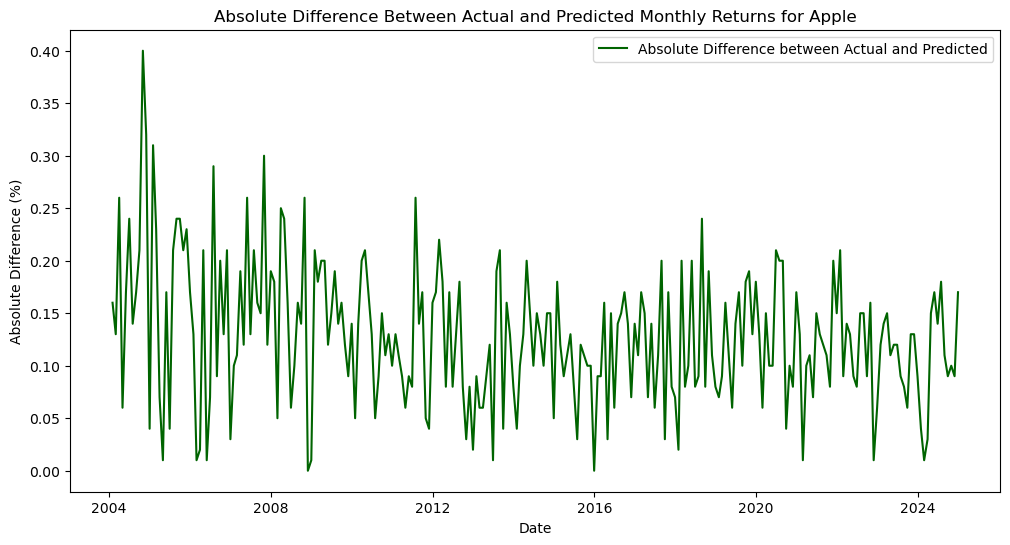

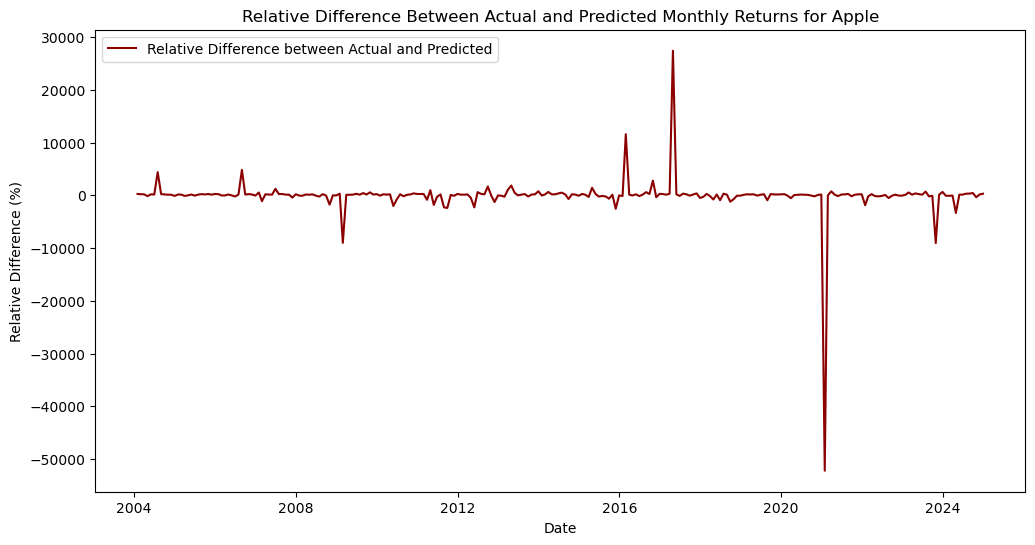

In [15]:
# Plot the actual vs. predicted monthly returns
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual Monthly Return'].str.rstrip('%').astype(float), label='Actual Monthly Return')
plt.plot(comparison_df.index, comparison_df['Predicted Monthly Return'].str.rstrip('%').astype(float), label='Predicted Monthly Return', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Monthly Return (%)')
plt.title('Actual vs. Predicted Monthly Returns for Apple')
plt.legend()
plt.show()

# Plot the absolute difference between actual and predicted monthly returns
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Absolute Difference between Actual and Predicted'].str.rstrip('%').astype(float), label='Absolute Difference between Actual and Predicted', color='darkgreen')
plt.xlabel('Date')
plt.ylabel('Absolute Difference (%)')
plt.title('Absolute Difference Between Actual and Predicted Monthly Returns for Apple')
plt.legend()
plt.show()

# Plot the relative difference
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Relative Difference between Actual and Predicted'].str.rstrip('%').astype(float), label='Relative Difference between Actual and Predicted', color='darkred')
plt.xlabel('Date')
plt.ylabel('Relative Difference (%)')
plt.title('Relative Difference Between Actual and Predicted Monthly Returns for Apple')
plt.legend()
plt.show()

In [17]:
# Calculate the range of differences for Actual vs. Predicted Monthly Returns
actual_vs_predicted_diff = (comparison_df['Actual Monthly Return'].str.rstrip('%').astype(float) - comparison_df['Predicted Monthly Return'].str.rstrip('%').astype(float))
diff_min = actual_vs_predicted_diff.min()
diff_max = actual_vs_predicted_diff.max()

# Calculate the range of absolute differences
absolute_diff_min = comparison_df['Absolute Difference between Actual and Predicted'].str.rstrip('%').astype(float).min()
absolute_diff_max = comparison_df['Absolute Difference between Actual and Predicted'].str.rstrip('%').astype(float).max()

# Calculate the range of relative differences
relative_diff_min = comparison_df['Relative Difference between Actual and Predicted'].str.rstrip('%').astype(float).min()
relative_diff_max = comparison_df['Relative Difference between Actual and Predicted'].str.rstrip('%').astype(float).max()

# Print the ranges
print(f"Overview of the discrepancies:")
print(f"\nActual vs. Predicted Monthly Returns Difference Range: {diff_min:.2f}% to {diff_max:.2f}%")
print(f"Absolute Difference Range: {absolute_diff_min:.2f}% to {absolute_diff_max:.2f}%")
print(f"Relative Difference Range: {relative_diff_min:.2f}% to {relative_diff_max:.2f}%")

Overview of the discrepancies:

Actual vs. Predicted Monthly Returns Difference Range: -0.17% to 0.40%
Absolute Difference Range: 0.00% to 0.40%
Relative Difference Range: -52235.12% to 27439.72%


**Observations from the visualizations include:**

We plotted three graphs for the actual vs. predicted monthly returns, the absolute difference between actual and predicted returns, and the relative difference between actual and predicted returns. Based on the above three graphs, we observe that:

- **Actual vs. Predicted Monthly Returns**: The first graph provides an overview of the differences between actual and predicted monthly returns, ranging from -0.17% to 0.40%, indicating that the model is relatively not accurately capturing the underlying patterns.

- **Absolute Difference**: The second graph visualizes the difference between actual and predicted monthly returns in absolute values, ranging from 0.00% to 0.41%, suggesting the model struggles to maintain accuracy across different time frames.

- **Relative Difference**: The third graph visualizes the difference between actual and predicted monthly returns in relative value in terms of the actual monthly returns. The graph reveals high relative errors, particularly during the months with smaller actual returns.

Overall, these observations suggest that while the model has some predictive capability  there is room for improvement. To enhance the model's accuracy, we may consider employing regularization techniques, exploring additional features, or experimenting with different model types. These steps can help build a more robust and reliable model for predicting the stock's monthly returns.